In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [3]:
from ultralytics import YOLO

In [ ]:
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
FileName = "2024_07_09_11_30_174.jpg"
raw_img = cv.imread(Directory + "/" + FileName)
img = cv.cvtColor(raw_img, cv.COLOR_BGR2GRAY)
img = raw_img

In [2]:
model = YOLO('best.pt', task='segment')

In [ ]:
model = YOLO('best.pt')
results = model(img, conf=0.3, save=True, show_labels=False, retina_masks=True)

**Pre and Post processing time**
- reduced from 5 seconds to ms by resizing the image before applying to the model

# Video Inferencing

In [ ]:
from ultralytics.utils.plotting import Annotator, colors

In [49]:
def im_show(img):
    cv.imshow('1', img)
    cv.waitKey()

In [106]:
# Camera Perspective View to Top View Transformation
def camera_angle2top_view():
    points = pd.read_csv('Points.csv')
    ref_pts = np.array([points.iloc[i,:2] for i in range(1, len(points))], dtype = 'uint16')
    dst_pts = np.array([points.iloc[i,2:] for i in range(1, len(points))], dtype = 'uint16')
    h, status = cv.findHomography(ref_pts, dst_pts)
    #print(ref_pts, dst_pts)
    return h

In [83]:
def InferenceImage(frame, model, width, height, conf, iou):
    img_resize = cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
    results = model(img_resize, conf=conf, iou=iou)
    return results

In [7]:
count_frame = 0
fps = 1
alpha = 0.8
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"

width = height = 640
Files = os.listdir(Directory)
Files = ['2024_07_09_11_30_114.jpg']#, '2024_07_09_11_30_115.jpg', '2024_07_09_11_30_116.jpg', '2024_07_09_11_30_117.jpg', '2024_07_09_11_30_118.jpg']
im_ref = cv.imread('ReferenceImage.jpg')
im_layout = cv.imread('SquareLayout.jpg')  

In [5]:
model = YOLO('best.pt')

In [8]:
res = InferenceImage(cv.imread(Directory + "/" + Files[0]), model, width, height)


0: 640x640 3 Fire-Smoke-Sodium-Trays, 5831.3ms
Speed: 75.1ms preprocess, 5831.3ms inference, 385.4ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
mask_img = np.any(np.array(res[0].masks[:].data), axis=0)
mask_img

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(232, 247) (255, 287)
(117, 262) (193, 376)
(287, 180) (314, 222)


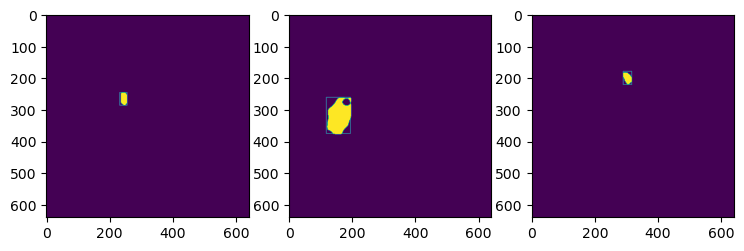

In [72]:
plt.figure(figsize=(12,6))
for i in range(len(res[0].masks)):
    plt.subplot(1,4,i+1)
    mask_img = np.any(np.array(res[0].masks[i].data), axis=0)
    plt.imshow(mask_img)
    plt.imshow(cv.rectangle(mask_img*255,tuple(np.array(res[0].boxes[i].data[0][:2], dtype='int')),tuple(np.array(res[0].boxes[i].data[0][2:4], dtype='int')),255,1))
    print(tuple(np.array(res[0].boxes[i].data[0][:2], dtype='int')),tuple(np.array(res[0].boxes[i].data[0][2:4], dtype='int')))

In [85]:
hierarchies[0]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [-1,  2, -1, -1]], dtype=int32)

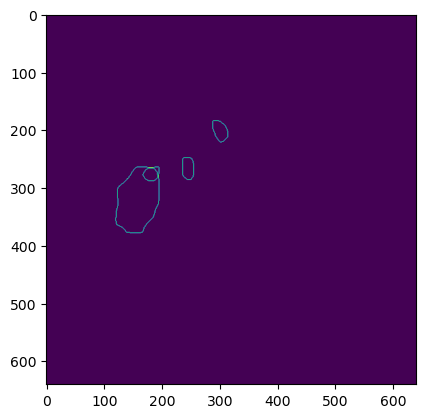

In [86]:
blank = np.zeros(mask_img.shape[:2], dtype='uint8')
plt.imshow(cv.drawContours(blank, contours, -1, (255, 0, 0), 1))

180 277
158 320
245 266
300 201


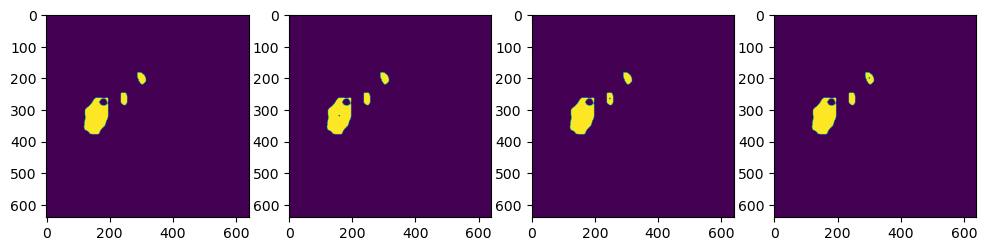

In [34]:
plt.figure(figsize=(12,6))
contours, hierarchies = cv.findContours(mask_img.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cnt=1
for i in contours:
    M = cv.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        print(cx, cy)
        plt.subplot(1,4,cnt)
        cnt += 1
        plt.imshow(cv.circle(mask_img.astype(np.uint8), (cx, cy), 2, (0, 0, 255), -1))
#         cv.drawContours(image, [i], -1, (0, 255, 0), 2)
#         cv.circle(image, (cx, cy), 7, (0, 0, 255), -1)
#         cv.putText(image, "center", (cx - 20, cy - 20),
#         cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
#         print(f"x: {cx} y: {cy}")

In [143]:
out = cv.VideoWriter("inst_segment.avi", cv.VideoWriter_fourcc(*"MJPG"), fps, (3*width, height))
#out2 = cv.VideoWriter("inst_seg_layout.avi", cv.VideoWriter_fourcc(*"MJPG"), fps, (im_layout.shape[1], im_layout.shape[0]))
video = cv.VideoCapture(r"F:\Work\SOCAAutomation\Dataset\NA_DISOPSAL_SOCA_2024\09072024\AXIS 213 - 10.1.5.173 2024-07-09_11_30_00_000.asf")
dur = [[3,0], [3,45]] #[mins,secs]
startFrame = (dur[0][0] * 60 + dur[0][1] ) * 15
endFrame = (dur[1][0] * 60 + dur[1][1] ) * 15

In [144]:
count_frame = 0
h = camera_angle2top_view()
while True:
    ret, frame = video.read()
    if ret:
        count_frame += 1
        if count_frame > startFrame and count_frame < endFrame:
            #frame = cv.imread(Directory + "/" + Files[count_frame])
            img_resize = cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
            results = model(img_resize, conf=0.5)
            if results[0].masks is not None:
                mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
                mask_img_3 = np.stack([np.zeros(mask_img.shape), mask_img, np.zeros(mask_img.shape)], axis=2)
                temp_image = cv.addWeighted(img_resize, alpha , (mask_img_3 * 255).astype('uint8'), 1-alpha, 0)        
                im_out = cv.warpPerspective(mask_img_3, h, (im_layout.shape[1],im_layout.shape[0]))
                im_layout_inv = 255 - im_layout
                layout_mask = cv.add(im_layout_inv, (im_out * 255).astype('uint8'))
                #layout_mask = cv.addWeighted(im_layout, 0.3 , (im_out * 255).astype('uint8'), 1-0.3, 0)
            else:
                temp_image = img_resize
                layout_mask = 255 - im_layout
                
            out.write(np.hstack([img_resize, temp_image, layout_mask]))
            #out2.write(layout_mask)        
    else:
        break
out.release()
#out2.release()
video.release()


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3615.2ms
Speed: 6.0ms preprocess, 3615.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4861.4ms
Speed: 7.0ms preprocess, 4861.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5109.9ms
Speed: 6.0ms preprocess, 5109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4075.5ms
Speed: 7.6ms preprocess, 4075.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4891.3ms
Speed: 15.5ms preprocess, 4891.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4923.4ms
Speed: 6.0ms preprocess, 4923.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 5982.0ms
Speed: 5.0ms preprocess, 5982.0ms inference, 610.1ms postprocess per imag

Speed: 10.0ms preprocess, 4408.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4127.7ms
Speed: 7.0ms preprocess, 4127.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3968.6ms
Speed: 6.0ms preprocess, 3968.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4019.6ms
Speed: 17.0ms preprocess, 4019.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3929.5ms
Speed: 7.1ms preprocess, 3929.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4580.1ms
Speed: 7.0ms preprocess, 4580.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4029.6ms
Speed: 7.0ms preprocess, 4029.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smok


0: 640x640 4 Fire-Smoke-Sodium-Trays, 5237.2ms
Speed: 9.0ms preprocess, 5237.2ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5297.8ms
Speed: 8.0ms preprocess, 5297.8ms inference, 32.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5176.7ms
Speed: 8.5ms preprocess, 5176.7ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5034.1ms
Speed: 9.0ms preprocess, 5034.1ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5721.3ms
Speed: 13.5ms preprocess, 5721.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 5451.9ms
Speed: 6.5ms preprocess, 5451.9ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Fire-Smoke-Sodium-Trays, 5403.9ms
Speed: 8.0ms preprocess, 5403.9ms inference, 30.5ms postprocess

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5655.1ms
Speed: 10.0ms preprocess, 5655.1ms inference, 19.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5300.8ms
Speed: 8.5ms preprocess, 5300.8ms inference, 16.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Fire-Smoke-Sodium-Trays, 5100.6ms
Speed: 8.0ms preprocess, 5100.6ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 5192.7ms
Speed: 6.0ms preprocess, 5192.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5622.6ms
Speed: 11.5ms preprocess, 5622.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5107.1ms
Speed: 8.0ms preprocess, 5107.1ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 5898.3ms
Speed: 12.0ms preprocess, 5898.3ms inference, 22.5ms postproces

Speed: 7.0ms preprocess, 3722.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3748.4ms
Speed: 6.0ms preprocess, 3748.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3762.4ms
Speed: 5.0ms preprocess, 3762.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3785.5ms
Speed: 6.0ms preprocess, 3785.5ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3638.3ms
Speed: 7.0ms preprocess, 3638.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3686.3ms
Speed: 6.0ms preprocess, 3686.3ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4231.8ms
Speed: 7.1ms preprocess, 4231.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fir

Speed: 7.0ms preprocess, 4290.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3748.4ms
Speed: 6.0ms preprocess, 3748.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5158.7ms
Speed: 7.0ms preprocess, 5158.7ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3892.5ms
Speed: 6.0ms preprocess, 3892.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4162.8ms
Speed: 7.0ms preprocess, 4162.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4475.0ms
Speed: 6.0ms preprocess, 4475.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4261.8ms
Speed: 6.0ms preprocess, 4261.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smok


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3918.5ms
Speed: 8.1ms preprocess, 3918.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3833.5ms
Speed: 6.0ms preprocess, 3833.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3857.5ms
Speed: 6.0ms preprocess, 3857.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5428.9ms
Speed: 6.0ms preprocess, 5428.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4198.8ms
Speed: 7.0ms preprocess, 4198.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4475.0ms
Speed: 7.0ms preprocess, 4475.0ms inference, 9.0ms postprocess per image a


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3930.5ms
Speed: 7.1ms preprocess, 3930.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 Fires, 3724.3ms
Speed: 7.1ms preprocess, 3724.3ms inference, 44.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4015.6ms
Speed: 13.0ms preprocess, 4015.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4038.6ms
Speed: 6.0ms preprocess, 4038.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3715.3ms
Speed: 7.1ms preprocess, 3715.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4371.0ms
Speed: 7.0ms preprocess, 4371.0ms inference, 6.0ms postprocess per image at shape (1, 3, 64


0: 640x640 (no detections), 6650.8ms
Speed: 8.0ms preprocess, 6650.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6418.3ms
Speed: 28.0ms preprocess, 6418.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5553.5ms
Speed: 9.0ms preprocess, 5553.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5535.0ms
Speed: 5.5ms preprocess, 5535.0ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5411.4ms
Speed: 8.0ms preprocess, 5411.4ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5144.6ms
Speed: 10.0ms preprocess, 5144.6ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 6376.4ms
Speed: 14.0ms preprocess, 6376.4ms inference, 10.0ms postprocess per image at shape (1, 3, 

Speed: 7.0ms preprocess, 5361.8ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5328.3ms
Speed: 11.5ms preprocess, 5328.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5030.2ms
Speed: 10.0ms preprocess, 5030.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5109.6ms
Speed: 8.5ms preprocess, 5109.6ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5803.3ms
Speed: 11.5ms preprocess, 5803.3ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5530.0ms
Speed: 13.0ms preprocess, 5530.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5205.2ms
Speed: 13.0ms preprocess, 5205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5322.8m


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4051.7ms
Speed: 9.0ms preprocess, 4051.7ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3981.6ms
Speed: 7.0ms preprocess, 3981.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3988.6ms
Speed: 6.0ms preprocess, 3988.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4137.7ms
Speed: 6.0ms preprocess, 4137.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4364.0ms
Speed: 6.0ms preprocess, 4364.0ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4146.8ms
Speed: 6.0ms preprocess, 4146.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4230.8ms
Speed: 7.0ms preprocess, 4230.8ms inference, 8.0ms postprocess per im


0: 640x640 (no detections), 4563.6ms
Speed: 7.9ms preprocess, 4563.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4550.6ms
Speed: 0.0ms preprocess, 4550.6ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4580.2ms
Speed: 0.0ms preprocess, 4580.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 4240.2ms
Speed: 10.0ms preprocess, 4240.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 3950.2ms
Speed: 10.0ms preprocess, 3950.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 4100.2ms
Speed: 10.0ms preprocess, 4100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 3900.2ms
Speed: 10.0ms preprocess, 3900.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (n

In [136]:
mask_img_3 = np.stack([np.zeros(mask_img.shape), mask_img, np.zeros(mask_img.shape)], axis=2)
temp_image = cv.addWeighted(img_resize, alpha , (mask_img_3 * 255).astype('uint8'), 1-alpha, 0)        
im_out = cv.warpPerspective(mask_img_3, h, (im_layout.shape[1],im_layout.shape[0]))

im_layout_inv = 255 - im_layout
layout_mask = cv.add(im_layout_inv, (im_out * 255).astype('uint8'))
im_show(np.hstack([temp_image, im_layout_inv, layout_mask]))


In [112]:
out.release()
out2.release()
video.release()

In [ ]:
alpha = 0.8
dst = cv.addWeighted(im1, alpha , im2, 1-alpha, 0) 
plt.imshow(im2)

In [ ]:
alpha = 0.6
im1 = cv.imread(r'F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1\2024_07_09_11_30_32.jpg')
im1 = cv.resize(im1, (640, 640), interpolation = cv.INTER_LINEAR)
#results = model(im1, conf=0.5) #, save=True, show_labels=False, retina_masks=True)
mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
orig_img = im1 #results[0].orig_img
mask_img_3 = np.stack([mask_img, np.zeros(mask_img.shape), np.zeros(mask_img.shape)], axis=2)

im2 = np.array(mask_img_3 * 255, dtype = 'uint8')

dst = cv.addWeighted(im1, alpha , im2, 1-alpha, 0) 
# mask_inv = np.logical_not(np.stack([mask_img, mask_img, mask_img], axis=2))
# temp_image = np.zeros(orig_img.shape)
# temp_image = mask_inv * orig_img
# temp_image += (mask_img_3 * 255).astype('uint8')


In [ ]:
plt.imshow(mask_img_3)

In [ ]:
plt.imshow(dst)

In [ ]:
frame = cv.imread(r'F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1\2024_07_09_11_30_344.jpg')
img_resize = cv.resize(frame, (640, 640), interpolation = cv.INTER_LINEAR)
cv.imwrite('ReferenceImage.jpg', img_resize)

# Transform Model to Onnx

In [ ]:
model.export(format="onnx")  # creates 'yolov8n_openvino_model/

In [ ]:
onnx_model = YOLO("best.onnx", task='segment')

In [ ]:
res_onnx = onnx_model(img, conf=0.3)

## ONNX Model Optimizations

### F32 to F16

In [ ]:
import onnx
from onnxconverter_common import float16

In [ ]:
onnx_model = onnx.load("best.onnx")
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model)
onnx.save(onnx_model_fp16, "model_fp16.onnx")

In [ ]:
onnx_model = YOLO("model_fp16.onnx", task='segment')

In [ ]:
res_onnx_fp16 = onnx_model(img, conf=0.3)

In [ ]:
img.dtype

# Transform Model to OpenVino

In [ ]:
model.export(format="openvino")  # creates 'yolov8n_openvino_model/

In [ ]:
ov_model = YOLO("yolov8n_openvino_model/")

# Run inference
results = ov_model("https://ultralytics.com/images/bus.jpg")

In [88]:
(15 / 240 ) * 640

40.0

# Feature Extraction from Segmented Image

- `Raw Image to Segmented image using inference model`
- `Calculate Centroid for each Mask`
- `Calculate size of each Mask`

### Input Configurations

In [94]:
Directory = r"F:\Work\SOCAAutomation\Dataset\NA_DISOPSAL_SOCA_2024\09072024"
VideoFile = "AXIS 213 - 10.1.5.173 2024-07-09_11_30_00_000.asf"
width = height = 640
conf = 0.5
iou = 0.7
dur = [[3,0], [3,45]] #[mins,secs]

### Input Processing

In [96]:
startFrame = (dur[0][0] * 60 + dur[0][1] ) * 15
endFrame = (dur[1][0] * 60 + dur[1][1] ) * 15
model = YOLO('best.pt')

### Function Definitions

In [129]:
def findCentroid(mask_img):
    contours, hierarchies = cv.findContours(mask_img.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    points = []
    area = []
    if len(contours) > 0:
        for i in contours:            
            M = cv.moments(i)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                points.append([cx, cy])
                area.append(M['m00'])
    return points, area

In [120]:
count_frame = 0
Frame_list = []
Centroid_list = []
Area_list = []
video = cv.VideoCapture(Directory + "/" + VideoFile)
while True:
    ret, frame = video.read()
    if ret:        
        count_frame += 1
        if count_frame > startFrame and count_frame < endFrame:
            print("Inferencing Frame " + str(count_frame) + "...")            
            results = InferenceImage(frame, model, width, height, conf, iou)
            if results[0].masks is not None:
                print("Mask identified for the frame...")
                mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
                Centroids, Area = findCentroid(mask_img)   
                Centroid_list.append(Centroids)
                Area_list.append(Area)
                Frame_list.append(count_frame)
    else:
        print("Error loading video")
        break
video.release()

Inferencing Frame 2701...



0: 640x640 1 Fire-Smoke-Sodium-Tray, 13398.1ms
Speed: 72.1ms preprocess, 13398.1ms inference, 110.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2702...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 6669.1ms
Speed: 31.0ms preprocess, 6669.1ms inference, 42.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2703...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4279.9ms
Speed: 36.0ms preprocess, 4279.9ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2704...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4807.3ms
Speed: 46.0ms preprocess, 4807.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2705...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4764.3ms
Speed: 9.0ms preprocess, 4764.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2706...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3733.4ms
Speed: 9.0ms preprocess, 3733.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2707...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4682.2ms
Speed: 7.0ms preprocess, 4682.2ms inference, 32.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2708...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4222.8ms
Speed: 6.0ms preprocess, 4222.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2709...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4584.1ms
Speed: 9.0ms preprocess, 4584.1ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2710...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4116.7ms
Speed: 12.0ms preprocess, 4116.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2711...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5095.6ms
Speed: 14.0ms preprocess, 5095.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2712...


0: 640x640 (no detections), 4576.1ms
Speed: 8.0ms preprocess, 4576.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2713...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4377.9ms
Speed: 6.0ms preprocess, 4377.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2714...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5246.7ms
Speed: 12.0ms preprocess, 5246.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2715...


0: 640x640 (no detections), 4358.9ms
Speed: 8.0ms preprocess, 4358.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2716...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4997.5ms
Speed: 6.0ms preprocess, 4997.5ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2717...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5336.8ms
Speed: 60.1ms preprocess, 5336.8ms inference, 41.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2718...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4848.4ms
Speed: 10.0ms preprocess, 4848.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2719...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5550.1ms
Speed: 6.0ms preprocess, 5550.1ms inference, 93.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2720...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5082.2ms
Speed: 46.2ms preprocess, 5082.2ms inference, 60.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2721...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4806.4ms
Speed: 8.0ms preprocess, 4806.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2722...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4681.2ms
Speed: 8.0ms preprocess, 4681.2ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2723...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4573.1ms
Speed: 8.0ms preprocess, 4573.1ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2724...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4202.8ms
Speed: 16.0ms preprocess, 4202.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2725...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4229.8ms
Speed: 10.0ms preprocess, 4229.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2726...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4018.6ms
Speed: 18.0ms preprocess, 4018.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2727...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4477.1ms
Speed: 7.0ms preprocess, 4477.1ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2728...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4277.9ms
Speed: 7.0ms preprocess, 4277.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2729...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3978.6ms
Speed: 6.0ms preprocess, 3978.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2730...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4017.6ms
Speed: 7.0ms preprocess, 4017.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2731...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4726.3ms
Speed: 6.0ms preprocess, 4726.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2732...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4425.0ms
Speed: 7.1ms preprocess, 4425.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2733...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3970.6ms
Speed: 6.0ms preprocess, 3970.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2734...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4783.3ms
Speed: 19.0ms preprocess, 4783.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2735...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4324.9ms
Speed: 40.0ms preprocess, 4324.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2736...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4730.7ms
Speed: 7.0ms preprocess, 4730.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2737...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4352.7ms
Speed: 7.5ms preprocess, 4352.7ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2738...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4695.4ms
Speed: 23.0ms preprocess, 4695.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2739...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4509.1ms
Speed: 29.0ms preprocess, 4509.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2740...


0: 640x640 (no detections), 4953.5ms
Speed: 15.0ms preprocess, 4953.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2741...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4965.5ms
Speed: 8.0ms preprocess, 4965.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2742...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5881.3ms
Speed: 209.2ms preprocess, 5881.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2743...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4902.4ms
Speed: 23.0ms preprocess, 4902.4ms inference, 52.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2744...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4947.5ms
Speed: 32.0ms preprocess, 4947.5ms inference, 97.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2745...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4846.4ms
Speed: 45.0ms preprocess, 4846.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2746...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4043.6ms
Speed: 7.0ms preprocess, 4043.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2747...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3960.6ms
Speed: 6.0ms preprocess, 3960.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2748...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3796.4ms
Speed: 43.0ms preprocess, 3796.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2749...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4298.9ms
Speed: 23.0ms preprocess, 4298.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2750...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4773.3ms
Speed: 6.0ms preprocess, 4773.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2751...


0: 640x640 (no detections), 4373.9ms
Speed: 7.0ms preprocess, 4373.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2752...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4991.5ms
Speed: 6.0ms preprocess, 4991.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2753...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4349.9ms
Speed: 20.0ms preprocess, 4349.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2754...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4152.7ms
Speed: 6.0ms preprocess, 4152.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2755...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3822.5ms
Speed: 6.0ms preprocess, 3822.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2756...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3748.3ms
Speed: 7.1ms preprocess, 3748.3ms inference, 79.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2757...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4143.7ms
Speed: 7.0ms preprocess, 4143.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2758...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3759.4ms
Speed: 19.0ms preprocess, 3759.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2759...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3657.3ms
Speed: 6.0ms preprocess, 3657.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2760...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3696.3ms
Speed: 6.0ms preprocess, 3696.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2761...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3970.6ms
Speed: 9.0ms preprocess, 3970.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2762...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3692.3ms
Speed: 7.0ms preprocess, 3692.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2763...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4103.7ms
Speed: 6.0ms preprocess, 4103.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2764...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3784.4ms
Speed: 17.0ms preprocess, 3784.4ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2765...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4212.8ms
Speed: 7.1ms preprocess, 4212.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2766...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3645.3ms
Speed: 7.0ms preprocess, 3645.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2767...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3520.2ms
Speed: 7.0ms preprocess, 3520.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2768...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3552.2ms
Speed: 7.0ms preprocess, 3552.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2769...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3739.4ms
Speed: 43.0ms preprocess, 3739.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2770...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3678.4ms
Speed: 6.0ms preprocess, 3678.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2771...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3702.3ms
Speed: 7.1ms preprocess, 3702.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2772...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3643.3ms
Speed: 6.0ms preprocess, 3643.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2773...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4113.7ms
Speed: 28.0ms preprocess, 4113.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2774...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3698.4ms
Speed: 6.0ms preprocess, 3698.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2775...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3609.3ms
Speed: 21.0ms preprocess, 3609.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2776...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3741.4ms
Speed: 25.0ms preprocess, 3741.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2777...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3855.5ms
Speed: 6.0ms preprocess, 3855.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2778...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3803.4ms
Speed: 6.1ms preprocess, 3803.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2779...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4098.7ms
Speed: 8.0ms preprocess, 4098.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2780...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3896.5ms
Speed: 6.0ms preprocess, 3896.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2781...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4360.9ms
Speed: 38.0ms preprocess, 4360.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2782...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3854.5ms
Speed: 47.0ms preprocess, 3854.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2783...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4066.7ms
Speed: 13.0ms preprocess, 4066.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2784...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4198.8ms
Speed: 7.0ms preprocess, 4198.8ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2785...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4539.1ms
Speed: 7.0ms preprocess, 4539.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2786...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3800.4ms
Speed: 6.0ms preprocess, 3800.4ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2787...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3796.4ms
Speed: 6.1ms preprocess, 3796.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2788...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4685.2ms
Speed: 6.0ms preprocess, 4685.2ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2789...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3786.4ms
Speed: 10.0ms preprocess, 3786.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2790...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3718.3ms
Speed: 6.0ms preprocess, 3718.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2791...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3767.4ms
Speed: 6.0ms preprocess, 3767.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2792...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3785.4ms
Speed: 6.0ms preprocess, 3785.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2793...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3896.5ms
Speed: 6.0ms preprocess, 3896.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2794...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3891.5ms
Speed: 7.0ms preprocess, 3891.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2795...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3709.3ms
Speed: 17.0ms preprocess, 3709.3ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2796...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4625.1ms
Speed: 7.0ms preprocess, 4625.1ms inference, 37.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2797...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3720.3ms
Speed: 7.0ms preprocess, 3720.3ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2798...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3585.2ms
Speed: 6.0ms preprocess, 3585.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2799...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3941.5ms
Speed: 7.0ms preprocess, 3941.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2800...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3603.2ms
Speed: 7.0ms preprocess, 3603.2ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2801...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3575.2ms
Speed: 6.1ms preprocess, 3575.2ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2802...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4806.3ms
Speed: 7.1ms preprocess, 4806.3ms inference, 33.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2803...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 5698.2ms
Speed: 47.0ms preprocess, 5698.2ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2804...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 5077.6ms
Speed: 7.0ms preprocess, 5077.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2805...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 5461.9ms
Speed: 8.0ms preprocess, 5461.9ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2806...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 5108.6ms
Speed: 8.0ms preprocess, 5108.6ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2807...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4213.8ms
Speed: 7.0ms preprocess, 4213.8ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2808...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4380.9ms
Speed: 7.0ms preprocess, 4380.9ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2809...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4147.7ms
Speed: 6.0ms preprocess, 4147.7ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2810...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4394.0ms
Speed: 13.0ms preprocess, 4394.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2811...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3600.2ms
Speed: 7.0ms preprocess, 3600.2ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2812...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3668.3ms
Speed: 6.0ms preprocess, 3668.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2813...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4042.6ms
Speed: 21.0ms preprocess, 4042.6ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2814...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4480.1ms
Speed: 7.1ms preprocess, 4480.1ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2815...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3643.3ms
Speed: 6.0ms preprocess, 3643.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2816...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3625.3ms
Speed: 7.0ms preprocess, 3625.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2817...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4145.7ms
Speed: 7.0ms preprocess, 4145.7ms inference, 26.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2818...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3633.2ms
Speed: 7.1ms preprocess, 3633.2ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2819...


0: 640x640 7 Fire-Smoke-Sodium-Trays, 3931.5ms
Speed: 15.0ms preprocess, 3931.5ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2820...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4051.6ms
Speed: 6.0ms preprocess, 4051.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2821...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4075.7ms
Speed: 7.0ms preprocess, 4075.7ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2822...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4173.8ms
Speed: 7.0ms preprocess, 4173.8ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2823...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3742.4ms
Speed: 6.0ms preprocess, 3742.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2824...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4001.7ms
Speed: 7.0ms preprocess, 4001.7ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2825...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4187.8ms
Speed: 6.0ms preprocess, 4187.8ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2826...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3513.2ms
Speed: 7.0ms preprocess, 3513.2ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2827...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3866.5ms
Speed: 27.0ms preprocess, 3866.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2828...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4053.6ms
Speed: 6.0ms preprocess, 4053.6ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2829...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3648.3ms
Speed: 7.0ms preprocess, 3648.3ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2830...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3769.4ms
Speed: 6.0ms preprocess, 3769.4ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2831...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3827.4ms
Speed: 7.0ms preprocess, 3827.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2832...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3712.3ms
Speed: 6.0ms preprocess, 3712.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2833...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4131.7ms
Speed: 7.1ms preprocess, 4131.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2834...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3771.4ms
Speed: 8.0ms preprocess, 3771.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2835...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3776.4ms
Speed: 17.0ms preprocess, 3776.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2836...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3643.3ms
Speed: 6.0ms preprocess, 3643.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2837...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4279.9ms
Speed: 45.0ms preprocess, 4279.9ms inference, 30.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2838...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4128.7ms
Speed: 6.0ms preprocess, 4128.7ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2839...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3680.4ms
Speed: 6.0ms preprocess, 3680.4ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2840...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4154.7ms
Speed: 6.0ms preprocess, 4154.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2841...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3705.3ms
Speed: 6.0ms preprocess, 3705.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2842...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3836.5ms
Speed: 8.0ms preprocess, 3836.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2843...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3854.4ms
Speed: 7.1ms preprocess, 3854.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2844...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3707.3ms
Speed: 21.0ms preprocess, 3707.3ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2845...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4077.7ms
Speed: 7.0ms preprocess, 4077.7ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2846...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3879.5ms
Speed: 7.1ms preprocess, 3879.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2847...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3810.4ms
Speed: 6.0ms preprocess, 3810.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2848...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4453.0ms
Speed: 6.0ms preprocess, 4453.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2849...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3865.5ms
Speed: 6.0ms preprocess, 3865.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2850...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4185.8ms
Speed: 7.0ms preprocess, 4185.8ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2851...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3762.4ms
Speed: 6.0ms preprocess, 3762.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2852...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4549.1ms
Speed: 6.0ms preprocess, 4549.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2853...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3767.4ms
Speed: 6.0ms preprocess, 3767.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2854...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3771.4ms
Speed: 8.0ms preprocess, 3771.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2855...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3834.5ms
Speed: 6.0ms preprocess, 3834.5ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2856...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3918.5ms
Speed: 7.0ms preprocess, 3918.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2857...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4064.7ms
Speed: 6.0ms preprocess, 4064.7ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2858...


0: 640x640 4 Fires, 4 Fire-Smoke-Sodium-Trays, 4277.9ms
Speed: 6.0ms preprocess, 4277.9ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2859...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4409.0ms
Speed: 6.0ms preprocess, 4409.0ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2860...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4107.7ms
Speed: 6.0ms preprocess, 4107.7ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2861...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4340.9ms
Speed: 7.0ms preprocess, 4340.9ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2862...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4885.4ms
Speed: 6.0ms preprocess, 4885.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2863...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4910.4ms
Speed: 7.0ms preprocess, 4910.4ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2864...


0: 640x640 20 Fires, 4 Fire-Smoke-Sodium-Trays, 4534.1ms
Speed: 7.0ms preprocess, 4534.1ms inference, 109.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2865...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3786.4ms
Speed: 56.1ms preprocess, 3786.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2866...


0: 640x640 51 Fires, 3 Fire-Smoke-Sodium-Trays, 4510.1ms
Speed: 9.0ms preprocess, 4510.1ms inference, 202.2ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2867...


0: 640x640 1 Fire, 3 Fire-Smoke-Sodium-Trays, 4058.7ms
Speed: 8.0ms preprocess, 4058.7ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2868...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4051.7ms
Speed: 7.0ms preprocess, 4051.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2869...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4719.3ms
Speed: 7.0ms preprocess, 4719.3ms inference, 39.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2870...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 3755.4ms
Speed: 32.0ms preprocess, 3755.4ms inference, 35.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2871...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4173.8ms
Speed: 15.0ms preprocess, 4173.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2872...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3761.4ms
Speed: 9.0ms preprocess, 3761.4ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2873...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3645.3ms
Speed: 8.0ms preprocess, 3645.3ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2874...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4021.6ms
Speed: 8.0ms preprocess, 4021.6ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2875...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3782.4ms
Speed: 8.0ms preprocess, 3782.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2876...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3858.5ms
Speed: 8.0ms preprocess, 3858.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2877...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4277.9ms
Speed: 9.0ms preprocess, 4277.9ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2878...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3942.6ms
Speed: 6.0ms preprocess, 3942.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2879...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3800.4ms
Speed: 6.0ms preprocess, 3800.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2880...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3975.6ms
Speed: 9.0ms preprocess, 3975.6ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2881...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3830.5ms
Speed: 10.0ms preprocess, 3830.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2882...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3868.5ms
Speed: 10.0ms preprocess, 3868.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2883...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4020.6ms
Speed: 9.0ms preprocess, 4020.6ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2884...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3916.5ms
Speed: 8.0ms preprocess, 3916.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2885...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4393.0ms
Speed: 7.0ms preprocess, 4393.0ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2886...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4215.8ms
Speed: 12.0ms preprocess, 4215.8ms inference, 31.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2887...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3763.4ms
Speed: 6.0ms preprocess, 3763.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2888...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3934.5ms
Speed: 8.0ms preprocess, 3934.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2889...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3676.3ms
Speed: 8.0ms preprocess, 3676.3ms inference, 18.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2890...


0: 640x640 2 Fires, 4 Fire-Smoke-Sodium-Trays, 3805.4ms
Speed: 9.0ms preprocess, 3805.4ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2891...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3917.5ms
Speed: 8.0ms preprocess, 3917.5ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2892...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4336.9ms
Speed: 8.0ms preprocess, 4336.9ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2893...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3815.4ms
Speed: 10.0ms preprocess, 3815.4ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2894...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3869.5ms
Speed: 9.0ms preprocess, 3869.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2895...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4119.7ms
Speed: 8.0ms preprocess, 4119.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2896...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3799.4ms
Speed: 12.0ms preprocess, 3799.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2897...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3695.4ms
Speed: 9.0ms preprocess, 3695.4ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2898...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3738.4ms
Speed: 8.0ms preprocess, 3738.4ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2899...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3833.5ms
Speed: 7.0ms preprocess, 3833.5ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2900...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4211.8ms
Speed: 14.0ms preprocess, 4211.8ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2901...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3836.5ms
Speed: 10.0ms preprocess, 3836.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2902...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3896.5ms
Speed: 9.0ms preprocess, 3896.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2903...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3744.4ms
Speed: 11.0ms preprocess, 3744.4ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2904...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3685.3ms
Speed: 10.0ms preprocess, 3685.3ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2905...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3782.4ms
Speed: 21.0ms preprocess, 3782.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2906...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3823.4ms
Speed: 25.0ms preprocess, 3823.4ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2907...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3855.5ms
Speed: 8.0ms preprocess, 3855.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2908...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4262.8ms
Speed: 8.0ms preprocess, 4262.8ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2909...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4030.7ms
Speed: 8.0ms preprocess, 4030.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2910...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3669.3ms
Speed: 10.0ms preprocess, 3669.3ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2911...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4301.9ms
Speed: 8.0ms preprocess, 4301.9ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2912...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3742.4ms
Speed: 8.0ms preprocess, 3742.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2913...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3850.5ms
Speed: 10.0ms preprocess, 3850.5ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2914...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4003.6ms
Speed: 8.0ms preprocess, 4003.6ms inference, 25.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2915...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4041.6ms
Speed: 7.0ms preprocess, 4041.6ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2916...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4965.5ms
Speed: 39.0ms preprocess, 4965.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2917...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3718.4ms
Speed: 8.0ms preprocess, 3718.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2918...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3887.5ms
Speed: 9.0ms preprocess, 3887.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2919...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3994.7ms
Speed: 10.0ms preprocess, 3994.7ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2920...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3775.4ms
Speed: 9.0ms preprocess, 3775.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2921...


0: 640x640 9 Fire-Smoke-Sodium-Trays, 3850.5ms
Speed: 9.0ms preprocess, 3850.5ms inference, 31.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2922...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3806.5ms
Speed: 9.0ms preprocess, 3806.5ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2923...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4191.8ms
Speed: 8.0ms preprocess, 4191.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2924...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4117.7ms
Speed: 10.0ms preprocess, 4117.7ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2925...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4238.8ms
Speed: 10.0ms preprocess, 4238.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2926...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4112.7ms
Speed: 12.0ms preprocess, 4112.7ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2927...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3797.4ms
Speed: 24.0ms preprocess, 3797.4ms inference, 23.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2928...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3696.3ms
Speed: 11.0ms preprocess, 3696.3ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2929...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3940.5ms
Speed: 10.0ms preprocess, 3940.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2930...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4050.6ms
Speed: 22.0ms preprocess, 4050.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2931...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4332.9ms
Speed: 9.0ms preprocess, 4332.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2932...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3803.4ms
Speed: 11.0ms preprocess, 3803.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2933...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3865.5ms
Speed: 8.0ms preprocess, 3865.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2934...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3795.4ms
Speed: 11.0ms preprocess, 3795.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2935...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3838.5ms
Speed: 16.0ms preprocess, 3838.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2936...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3680.3ms
Speed: 10.0ms preprocess, 3680.3ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2937...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4130.7ms
Speed: 10.0ms preprocess, 4130.7ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2938...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4402.0ms
Speed: 13.0ms preprocess, 4402.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2939...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3943.6ms
Speed: 10.0ms preprocess, 3943.6ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2940...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4106.7ms
Speed: 9.0ms preprocess, 4106.7ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2941...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3739.4ms
Speed: 8.0ms preprocess, 3739.4ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2942...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3784.4ms
Speed: 8.0ms preprocess, 3784.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2943...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3729.4ms
Speed: 8.0ms preprocess, 3729.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2944...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3988.6ms
Speed: 11.0ms preprocess, 3988.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2945...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3924.6ms
Speed: 10.0ms preprocess, 3924.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2946...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4225.8ms
Speed: 9.0ms preprocess, 4225.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2947...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3698.3ms
Speed: 9.0ms preprocess, 3698.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2948...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3720.4ms
Speed: 11.0ms preprocess, 3720.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2949...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3786.4ms
Speed: 9.0ms preprocess, 3786.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2950...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3651.3ms
Speed: 6.0ms preprocess, 3651.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2951...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3865.5ms
Speed: 10.0ms preprocess, 3865.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2952...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3892.5ms
Speed: 17.0ms preprocess, 3892.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2953...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4085.7ms
Speed: 10.0ms preprocess, 4085.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2954...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4275.8ms
Speed: 15.0ms preprocess, 4275.8ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2955...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4040.6ms
Speed: 11.0ms preprocess, 4040.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2956...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4205.8ms
Speed: 8.0ms preprocess, 4205.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2957...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3854.5ms
Speed: 10.0ms preprocess, 3854.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2958...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3888.5ms
Speed: 9.0ms preprocess, 3888.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2959...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3898.5ms
Speed: 7.0ms preprocess, 3898.5ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2960...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3913.5ms
Speed: 10.0ms preprocess, 3913.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2961...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4268.8ms
Speed: 6.0ms preprocess, 4268.8ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2962...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3974.6ms
Speed: 13.0ms preprocess, 3974.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2963...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3896.5ms
Speed: 10.0ms preprocess, 3896.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2964...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3632.3ms
Speed: 9.0ms preprocess, 3632.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2965...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3621.3ms
Speed: 7.0ms preprocess, 3621.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2966...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3801.4ms
Speed: 8.0ms preprocess, 3801.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2967...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3863.5ms
Speed: 18.0ms preprocess, 3863.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2968...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3897.5ms
Speed: 10.0ms preprocess, 3897.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2969...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4366.9ms
Speed: 8.0ms preprocess, 4366.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2970...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3804.4ms
Speed: 7.0ms preprocess, 3804.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2971...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4223.8ms
Speed: 12.0ms preprocess, 4223.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2972...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3739.4ms
Speed: 8.0ms preprocess, 3739.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2973...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3723.4ms
Speed: 8.0ms preprocess, 3723.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2974...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3656.3ms
Speed: 9.0ms preprocess, 3656.3ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2975...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3751.4ms
Speed: 9.0ms preprocess, 3751.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2976...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3891.5ms
Speed: 33.0ms preprocess, 3891.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2977...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4339.9ms
Speed: 10.0ms preprocess, 4339.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2978...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3759.4ms
Speed: 10.0ms preprocess, 3759.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2979...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3812.4ms
Speed: 8.0ms preprocess, 3812.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2980...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3850.5ms
Speed: 11.0ms preprocess, 3850.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2981...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3682.3ms
Speed: 7.0ms preprocess, 3682.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2982...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3751.4ms
Speed: 7.0ms preprocess, 3751.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2983...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4058.7ms
Speed: 8.0ms preprocess, 4058.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2984...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3929.5ms
Speed: 9.0ms preprocess, 3929.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2985...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4212.8ms
Speed: 25.0ms preprocess, 4212.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2986...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4354.9ms
Speed: 9.0ms preprocess, 4354.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2987...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3754.4ms
Speed: 9.0ms preprocess, 3754.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2988...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3877.5ms
Speed: 7.0ms preprocess, 3877.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2989...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3718.4ms
Speed: 11.0ms preprocess, 3718.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2990...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3672.3ms
Speed: 10.0ms preprocess, 3672.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2991...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3874.5ms
Speed: 9.0ms preprocess, 3874.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2992...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4148.7ms
Speed: 11.0ms preprocess, 4148.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2993...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3724.4ms
Speed: 9.0ms preprocess, 3724.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2994...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3756.4ms
Speed: 25.0ms preprocess, 3756.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2995...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3713.3ms
Speed: 46.0ms preprocess, 3713.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2996...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4104.7ms
Speed: 7.0ms preprocess, 4104.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2997...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3825.4ms
Speed: 9.0ms preprocess, 3825.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2998...


0: 640x640 (no detections), 3719.3ms
Speed: 8.0ms preprocess, 3719.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2999...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4018.6ms
Speed: 6.0ms preprocess, 4018.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3000...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4261.8ms
Speed: 10.0ms preprocess, 4261.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3001...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4305.9ms
Speed: 9.0ms preprocess, 4305.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3002...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3837.5ms
Speed: 11.0ms preprocess, 3837.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3003...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3760.4ms
Speed: 23.0ms preprocess, 3760.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3004...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3769.4ms
Speed: 9.0ms preprocess, 3769.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3005...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3695.3ms
Speed: 10.0ms preprocess, 3695.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3006...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3677.3ms
Speed: 15.0ms preprocess, 3677.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3007...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4449.0ms
Speed: 10.0ms preprocess, 4449.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3008...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4020.6ms
Speed: 11.0ms preprocess, 4020.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3009...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3802.4ms
Speed: 6.0ms preprocess, 3802.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3010...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3655.3ms
Speed: 26.0ms preprocess, 3655.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3011...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3748.4ms
Speed: 7.0ms preprocess, 3748.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3012...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3747.4ms
Speed: 19.0ms preprocess, 3747.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3013...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3835.5ms
Speed: 10.0ms preprocess, 3835.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3014...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3840.5ms
Speed: 7.0ms preprocess, 3840.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3015...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3943.6ms
Speed: 10.0ms preprocess, 3943.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3016...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4493.0ms
Speed: 11.0ms preprocess, 4493.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3017...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3728.4ms
Speed: 15.0ms preprocess, 3728.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3018...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3759.4ms
Speed: 10.0ms preprocess, 3759.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3019...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3591.2ms
Speed: 10.0ms preprocess, 3591.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3020...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3739.4ms
Speed: 9.0ms preprocess, 3739.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3021...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3867.5ms
Speed: 7.0ms preprocess, 3867.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3022...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3986.6ms
Speed: 9.0ms preprocess, 3986.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3023...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4086.7ms
Speed: 11.0ms preprocess, 4086.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3024...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3919.5ms
Speed: 20.0ms preprocess, 3919.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3025...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3824.4ms
Speed: 7.0ms preprocess, 3824.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3026...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3773.4ms
Speed: 7.0ms preprocess, 3773.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3027...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3685.3ms
Speed: 8.0ms preprocess, 3685.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3028...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3800.4ms
Speed: 10.0ms preprocess, 3800.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3029...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3869.5ms
Speed: 8.0ms preprocess, 3869.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3030...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4107.7ms
Speed: 5.0ms preprocess, 4107.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3031...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4099.7ms
Speed: 10.0ms preprocess, 4099.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3032...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4325.9ms
Speed: 8.0ms preprocess, 4325.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3033...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3730.4ms
Speed: 18.0ms preprocess, 3730.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3034...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3760.4ms
Speed: 7.0ms preprocess, 3760.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3035...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3886.5ms
Speed: 11.0ms preprocess, 3886.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3036...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3783.4ms
Speed: 8.0ms preprocess, 3783.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3037...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3801.4ms
Speed: 9.0ms preprocess, 3801.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3038...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3994.6ms
Speed: 10.0ms preprocess, 3994.6ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3039...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4072.7ms
Speed: 10.0ms preprocess, 4072.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3040...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3903.5ms
Speed: 9.0ms preprocess, 3903.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3041...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3683.3ms
Speed: 10.0ms preprocess, 3683.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3042...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3824.4ms
Speed: 10.0ms preprocess, 3824.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3043...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3667.3ms
Speed: 9.0ms preprocess, 3667.3ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3044...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3880.5ms
Speed: 7.0ms preprocess, 3880.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3045...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3821.4ms
Speed: 8.0ms preprocess, 3821.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3046...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3960.6ms
Speed: 10.0ms preprocess, 3960.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3047...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4701.2ms
Speed: 9.0ms preprocess, 4701.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3048...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3790.4ms
Speed: 10.0ms preprocess, 3790.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3049...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3926.5ms
Speed: 9.0ms preprocess, 3926.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3050...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3774.4ms
Speed: 10.0ms preprocess, 3774.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3051...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3722.4ms
Speed: 10.0ms preprocess, 3722.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3052...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3942.6ms
Speed: 10.0ms preprocess, 3942.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3053...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4138.7ms
Speed: 10.0ms preprocess, 4138.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3054...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4149.7ms
Speed: 9.0ms preprocess, 4149.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3055...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3776.4ms
Speed: 9.0ms preprocess, 3776.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3056...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3830.5ms
Speed: 9.0ms preprocess, 3830.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3057...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3804.4ms
Speed: 9.0ms preprocess, 3804.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3058...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3728.4ms
Speed: 10.0ms preprocess, 3728.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3059...


0: 640x640 (no detections), 3790.4ms
Speed: 9.0ms preprocess, 3790.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3060...


0: 640x640 (no detections), 3953.6ms
Speed: 7.0ms preprocess, 3953.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3061...


0: 640x640 (no detections), 4174.8ms
Speed: 6.0ms preprocess, 4174.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3062...


0: 640x640 (no detections), 4703.2ms
Speed: 7.0ms preprocess, 4703.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3063...


0: 640x640 (no detections), 3825.4ms
Speed: 6.0ms preprocess, 3825.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3064...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3697.3ms
Speed: 8.0ms preprocess, 3697.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3065...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3691.3ms
Speed: 11.0ms preprocess, 3691.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3066...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3798.4ms
Speed: 10.0ms preprocess, 3798.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3067...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3677.4ms
Speed: 11.0ms preprocess, 3677.4ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3068...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3839.5ms
Speed: 11.0ms preprocess, 3839.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3069...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3847.5ms
Speed: 16.0ms preprocess, 3847.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3070...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4181.8ms
Speed: 6.0ms preprocess, 4181.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3071...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3832.5ms
Speed: 10.0ms preprocess, 3832.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3072...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3836.5ms
Speed: 9.0ms preprocess, 3836.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3073...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3829.5ms
Speed: 10.0ms preprocess, 3829.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3074...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3811.4ms
Speed: 9.0ms preprocess, 3811.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3075...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3726.4ms
Speed: 7.0ms preprocess, 3726.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3076...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3967.6ms
Speed: 11.0ms preprocess, 3967.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3077...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4201.8ms
Speed: 15.0ms preprocess, 4201.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3078...


0: 640x640 (no detections), 4377.0ms
Speed: 12.0ms preprocess, 4377.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3079...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3824.4ms
Speed: 6.0ms preprocess, 3824.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3080...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3732.4ms
Speed: 9.0ms preprocess, 3732.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3081...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3777.4ms
Speed: 7.0ms preprocess, 3777.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3082...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3794.5ms
Speed: 10.0ms preprocess, 3794.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3083...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3932.5ms
Speed: 7.0ms preprocess, 3932.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3084...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4127.7ms
Speed: 7.0ms preprocess, 4127.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3085...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3930.5ms
Speed: 8.0ms preprocess, 3930.5ms inference, 25.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3086...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3955.6ms
Speed: 20.0ms preprocess, 3955.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3087...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3853.5ms
Speed: 10.0ms preprocess, 3853.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3088...


0: 640x640 (no detections), 3759.4ms
Speed: 8.0ms preprocess, 3759.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3089...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3728.4ms
Speed: 6.0ms preprocess, 3728.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3090...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4051.6ms
Speed: 6.0ms preprocess, 4051.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3091...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3981.6ms
Speed: 7.0ms preprocess, 3981.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3092...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3994.6ms
Speed: 7.0ms preprocess, 3994.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3093...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4470.1ms
Speed: 8.0ms preprocess, 4470.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3094...


0: 640x640 12 Fires, 3811.4ms
Speed: 10.0ms preprocess, 3811.4ms inference, 48.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3095...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3753.4ms
Speed: 8.0ms preprocess, 3753.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3096...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4289.9ms
Speed: 7.0ms preprocess, 4289.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3097...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3780.4ms
Speed: 7.0ms preprocess, 3780.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3098...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3743.4ms
Speed: 7.0ms preprocess, 3743.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3099...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4093.7ms
Speed: 7.0ms preprocess, 4093.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3100...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3744.4ms
Speed: 7.0ms preprocess, 3744.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3101...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4186.8ms
Speed: 8.0ms preprocess, 4186.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3102...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3706.4ms
Speed: 6.0ms preprocess, 3706.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3103...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3809.4ms
Speed: 9.0ms preprocess, 3809.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3104...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3803.5ms
Speed: 9.0ms preprocess, 3803.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3105...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3707.3ms
Speed: 10.0ms preprocess, 3707.3ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3106...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3895.5ms
Speed: 7.0ms preprocess, 3895.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3107...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3730.4ms
Speed: 7.0ms preprocess, 3730.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3108...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4246.9ms
Speed: 9.0ms preprocess, 4246.9ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3109...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4164.8ms
Speed: 10.0ms preprocess, 4164.8ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3110...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3844.5ms
Speed: 10.0ms preprocess, 3844.5ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3111...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3662.3ms
Speed: 10.0ms preprocess, 3662.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3112...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3706.3ms
Speed: 9.0ms preprocess, 3706.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3113...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3896.6ms
Speed: 8.0ms preprocess, 3896.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3114...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4104.7ms
Speed: 8.0ms preprocess, 4104.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3115...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4003.6ms
Speed: 7.0ms preprocess, 4003.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3116...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4013.6ms
Speed: 8.0ms preprocess, 4013.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3117...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3738.4ms
Speed: 7.0ms preprocess, 3738.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3118...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3822.4ms
Speed: 7.0ms preprocess, 3822.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3119...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3771.4ms
Speed: 10.0ms preprocess, 3771.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3120...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3845.5ms
Speed: 10.0ms preprocess, 3845.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3121...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3988.6ms
Speed: 8.0ms preprocess, 3988.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3122...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3878.5ms
Speed: 7.0ms preprocess, 3878.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3123...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4384.0ms
Speed: 6.0ms preprocess, 4384.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3124...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4104.7ms
Speed: 8.0ms preprocess, 4104.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3125...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3670.3ms
Speed: 10.0ms preprocess, 3670.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3126...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3823.4ms
Speed: 9.0ms preprocess, 3823.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3127...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3730.4ms
Speed: 7.0ms preprocess, 3730.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3128...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3734.4ms
Speed: 7.0ms preprocess, 3734.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3129...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4433.0ms
Speed: 7.0ms preprocess, 4433.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3130...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4030.6ms
Speed: 6.0ms preprocess, 4030.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3131...


0: 640x640 (no detections), 3804.4ms
Speed: 7.0ms preprocess, 3804.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3132...


0: 640x640 (no detections), 4057.7ms
Speed: 8.0ms preprocess, 4057.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3133...


0: 640x640 5 Fires, 3757.4ms
Speed: 7.0ms preprocess, 3757.4ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3134...


0: 640x640 (no detections), 3805.4ms
Speed: 10.0ms preprocess, 3805.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3135...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3816.4ms
Speed: 7.0ms preprocess, 3816.4ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3136...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3727.4ms
Speed: 6.0ms preprocess, 3727.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3137...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3914.5ms
Speed: 5.0ms preprocess, 3914.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3138...


0: 640x640 (no detections), 4131.7ms
Speed: 6.0ms preprocess, 4131.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3139...


0: 640x640 (no detections), 3766.4ms
Speed: 6.0ms preprocess, 3766.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3140...


0: 640x640 (no detections), 4028.6ms
Speed: 7.0ms preprocess, 4028.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3141...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3747.4ms
Speed: 7.0ms preprocess, 3747.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3142...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3642.3ms
Speed: 6.0ms preprocess, 3642.3ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3143...


0: 640x640 (no detections), 3858.5ms
Speed: 6.0ms preprocess, 3858.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3144...


0: 640x640 (no detections), 3793.4ms
Speed: 7.0ms preprocess, 3793.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3145...


0: 640x640 (no detections), 4028.6ms
Speed: 6.0ms preprocess, 4028.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3146...


0: 640x640 (no detections), 4057.7ms
Speed: 6.0ms preprocess, 4057.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3147...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4604.2ms
Speed: 6.0ms preprocess, 4604.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3148...


0: 640x640 (no detections), 3692.3ms
Speed: 6.0ms preprocess, 3692.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3149...


0: 640x640 (no detections), 3680.3ms
Speed: 7.0ms preprocess, 3680.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3150...


0: 640x640 (no detections), 3647.3ms
Speed: 7.0ms preprocess, 3647.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3151...


0: 640x640 (no detections), 3892.5ms
Speed: 5.0ms preprocess, 3892.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3152...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3795.4ms
Speed: 9.0ms preprocess, 3795.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3153...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3819.4ms
Speed: 6.0ms preprocess, 3819.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3154...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4092.7ms
Speed: 7.0ms preprocess, 4092.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3155...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4002.6ms
Speed: 5.0ms preprocess, 4002.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3156...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3699.3ms
Speed: 6.0ms preprocess, 3699.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3157...


0: 640x640 (no detections), 3751.4ms
Speed: 6.0ms preprocess, 3751.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3158...


0: 640x640 (no detections), 3814.4ms
Speed: 6.0ms preprocess, 3814.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3159...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3910.5ms
Speed: 6.0ms preprocess, 3910.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3160...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4009.6ms
Speed: 7.0ms preprocess, 4009.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3161...


0: 640x640 (no detections), 3884.5ms
Speed: 7.1ms preprocess, 3884.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3162...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3834.5ms
Speed: 7.0ms preprocess, 3834.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3163...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4098.8ms
Speed: 7.0ms preprocess, 4098.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3164...


0: 640x640 1 Fire, 1 Fire-Smoke-Sodium-Tray, 4004.7ms
Speed: 7.0ms preprocess, 4004.7ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3165...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3901.5ms
Speed: 23.0ms preprocess, 3901.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3166...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3912.5ms
Speed: 7.0ms preprocess, 3912.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3167...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3977.6ms
Speed: 7.0ms preprocess, 3977.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3168...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3888.5ms
Speed: 6.0ms preprocess, 3888.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3169...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4975.5ms
Speed: 6.0ms preprocess, 4975.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3170...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3696.3ms
Speed: 6.0ms preprocess, 3696.3ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3171...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3951.6ms
Speed: 9.0ms preprocess, 3951.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3172...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3778.4ms
Speed: 12.0ms preprocess, 3778.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3173...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3762.4ms
Speed: 6.0ms preprocess, 3762.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3174...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3696.3ms
Speed: 6.0ms preprocess, 3696.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3175...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4209.8ms
Speed: 7.0ms preprocess, 4209.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3176...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3933.5ms
Speed: 7.0ms preprocess, 3933.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3177...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4386.0ms
Speed: 6.0ms preprocess, 4386.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3178...


0: 640x640 (no detections), 4492.0ms
Speed: 7.0ms preprocess, 4492.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3179...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4397.0ms
Speed: 7.0ms preprocess, 4397.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3180...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3956.6ms
Speed: 6.0ms preprocess, 3956.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3181...


0: 640x640 (no detections), 4106.7ms
Speed: 7.0ms preprocess, 4106.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3182...


0: 640x640 (no detections), 3952.6ms
Speed: 6.0ms preprocess, 3952.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3183...


0: 640x640 (no detections), 4039.6ms
Speed: 6.0ms preprocess, 4039.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3184...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4193.8ms
Speed: 7.0ms preprocess, 4193.8ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3185...


0: 640x640 (no detections), 4304.9ms
Speed: 7.0ms preprocess, 4304.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3186...


0: 640x640 (no detections), 3881.5ms
Speed: 8.0ms preprocess, 3881.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3187...


0: 640x640 (no detections), 3970.6ms
Speed: 6.0ms preprocess, 3970.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3188...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3925.5ms
Speed: 6.0ms preprocess, 3925.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3189...


0: 640x640 (no detections), 3914.5ms
Speed: 5.0ms preprocess, 3914.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3190...


0: 640x640 (no detections), 3954.6ms
Speed: 6.0ms preprocess, 3954.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3191...


0: 640x640 (no detections), 4329.9ms
Speed: 6.0ms preprocess, 4329.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3192...


0: 640x640 (no detections), 3959.6ms
Speed: 8.0ms preprocess, 3959.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3193...


0: 640x640 (no detections), 4203.8ms
Speed: 8.0ms preprocess, 4203.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3194...


0: 640x640 (no detections), 3792.4ms
Speed: 6.0ms preprocess, 3792.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3195...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4080.7ms
Speed: 6.0ms preprocess, 4080.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3196...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3934.5ms
Speed: 6.0ms preprocess, 3934.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3197...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4034.6ms
Speed: 7.1ms preprocess, 4034.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3198...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4013.6ms
Speed: 7.0ms preprocess, 4013.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3199...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4002.6ms
Speed: 6.0ms preprocess, 4002.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3200...


0: 640x640 (no detections), 3925.5ms
Speed: 5.0ms preprocess, 3925.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3201...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4512.1ms
Speed: 6.0ms preprocess, 4512.1ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3202...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3808.4ms
Speed: 7.0ms preprocess, 3808.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3203...


0: 640x640 (no detections), 3881.5ms
Speed: 7.0ms preprocess, 3881.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3204...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3806.4ms
Speed: 7.1ms preprocess, 3806.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3205...


0: 640x640 (no detections), 3690.3ms
Speed: 6.0ms preprocess, 3690.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3206...


0: 640x640 (no detections), 3904.5ms
Speed: 6.0ms preprocess, 3904.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3207...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3840.5ms
Speed: 5.0ms preprocess, 3840.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3208...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4230.8ms
Speed: 6.0ms preprocess, 4230.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3209...


0: 640x640 (no detections), 3906.5ms
Speed: 6.1ms preprocess, 3906.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3210...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4016.6ms
Speed: 6.0ms preprocess, 4016.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3211...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4127.7ms
Speed: 6.0ms preprocess, 4127.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3212...


0: 640x640 (no detections), 3979.6ms
Speed: 6.0ms preprocess, 3979.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3213...


0: 640x640 (no detections), 3967.6ms
Speed: 6.0ms preprocess, 3967.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3214...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3975.6ms
Speed: 6.0ms preprocess, 3975.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3215...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4316.9ms
Speed: 6.0ms preprocess, 4316.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3216...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4201.8ms
Speed: 6.0ms preprocess, 4201.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3217...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3712.3ms
Speed: 6.0ms preprocess, 3712.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3218...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3845.5ms
Speed: 7.0ms preprocess, 3845.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3219...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3816.4ms
Speed: 6.0ms preprocess, 3816.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3220...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3891.5ms
Speed: 6.0ms preprocess, 3891.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3221...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3681.3ms
Speed: 6.0ms preprocess, 3681.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3222...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3946.6ms
Speed: 9.0ms preprocess, 3946.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3223...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3663.3ms
Speed: 5.0ms preprocess, 3663.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3224...


0: 640x640 (no detections), 4101.7ms
Speed: 14.0ms preprocess, 4101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3225...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3821.5ms
Speed: 6.0ms preprocess, 3821.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3226...


0: 640x640 (no detections), 3783.5ms
Speed: 6.0ms preprocess, 3783.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3227...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3766.4ms
Speed: 6.0ms preprocess, 3766.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3228...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4089.7ms
Speed: 6.0ms preprocess, 4089.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3229...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3859.5ms
Speed: 7.0ms preprocess, 3859.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3230...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3919.5ms
Speed: 7.0ms preprocess, 3919.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3231...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4032.6ms
Speed: 7.0ms preprocess, 4032.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3232...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3704.4ms
Speed: 6.0ms preprocess, 3704.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3233...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3827.4ms
Speed: 7.1ms preprocess, 3827.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3234...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3771.4ms
Speed: 5.0ms preprocess, 3771.4ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3235...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3737.4ms
Speed: 6.0ms preprocess, 3737.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3236...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3948.6ms
Speed: 6.0ms preprocess, 3948.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3237...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3655.3ms
Speed: 7.0ms preprocess, 3655.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3238...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3879.5ms
Speed: 7.0ms preprocess, 3879.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3239...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3963.6ms
Speed: 6.0ms preprocess, 3963.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3240...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3795.4ms
Speed: 6.0ms preprocess, 3795.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3241...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3750.4ms
Speed: 6.0ms preprocess, 3750.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3242...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3757.4ms
Speed: 6.0ms preprocess, 3757.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3243...


0: 640x640 (no detections), 3759.4ms
Speed: 6.0ms preprocess, 3759.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3244...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3868.5ms
Speed: 9.0ms preprocess, 3868.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3245...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3709.3ms
Speed: 6.0ms preprocess, 3709.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3246...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3859.5ms
Speed: 5.0ms preprocess, 3859.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3247...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4126.7ms
Speed: 5.0ms preprocess, 4126.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3248...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3892.5ms
Speed: 5.0ms preprocess, 3892.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3249...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3891.5ms
Speed: 6.0ms preprocess, 3891.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3250...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3741.4ms
Speed: 6.0ms preprocess, 3741.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3251...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4377.9ms
Speed: 6.0ms preprocess, 4377.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3252...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3656.3ms
Speed: 6.0ms preprocess, 3656.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3253...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3876.5ms
Speed: 6.0ms preprocess, 3876.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3254...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3628.3ms
Speed: 6.0ms preprocess, 3628.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3255...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4123.7ms
Speed: 7.0ms preprocess, 4123.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3256...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3896.5ms
Speed: 6.0ms preprocess, 3896.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3257...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4145.7ms
Speed: 6.0ms preprocess, 4145.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3258...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4186.8ms
Speed: 7.0ms preprocess, 4186.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3259...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4502.0ms
Speed: 7.0ms preprocess, 4502.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3260...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4348.0ms
Speed: 6.0ms preprocess, 4348.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3261...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4095.7ms
Speed: 7.0ms preprocess, 4095.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3262...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4206.8ms
Speed: 7.0ms preprocess, 4206.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3263...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4111.7ms
Speed: 6.0ms preprocess, 4111.7ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3264...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4262.8ms
Speed: 7.0ms preprocess, 4262.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3265...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3921.5ms
Speed: 6.0ms preprocess, 3921.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3266...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3897.5ms
Speed: 6.0ms preprocess, 3897.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3267...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3958.6ms
Speed: 6.0ms preprocess, 3958.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3268...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3919.5ms
Speed: 7.0ms preprocess, 3919.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3269...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3753.4ms
Speed: 7.0ms preprocess, 3753.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3270...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4130.7ms
Speed: 5.0ms preprocess, 4130.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3271...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3733.4ms
Speed: 6.0ms preprocess, 3733.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3272...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4231.8ms
Speed: 6.0ms preprocess, 4231.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3273...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3915.5ms
Speed: 6.0ms preprocess, 3915.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3274...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4430.0ms
Speed: 6.0ms preprocess, 4430.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3275...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5244.7ms
Speed: 7.0ms preprocess, 5244.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3276...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4699.2ms
Speed: 7.0ms preprocess, 4699.2ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3277...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4506.1ms
Speed: 45.0ms preprocess, 4506.1ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3278...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4019.6ms
Speed: 6.0ms preprocess, 4019.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3279...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4511.1ms
Speed: 8.0ms preprocess, 4511.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3280...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3778.4ms
Speed: 7.0ms preprocess, 3778.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3281...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4199.8ms
Speed: 6.0ms preprocess, 4199.8ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3282...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4224.8ms
Speed: 7.0ms preprocess, 4224.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3283...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4017.6ms
Speed: 7.0ms preprocess, 4017.6ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3284...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4329.9ms
Speed: 6.0ms preprocess, 4329.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3285...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3939.5ms
Speed: 7.0ms preprocess, 3939.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3286...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4175.8ms
Speed: 8.0ms preprocess, 4175.8ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3287...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3812.4ms
Speed: 6.0ms preprocess, 3812.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3288...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4850.4ms
Speed: 6.0ms preprocess, 4850.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3289...


0: 640x640 (no detections), 5160.6ms
Speed: 7.0ms preprocess, 5160.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3290...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4294.9ms
Speed: 7.0ms preprocess, 4294.9ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3291...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4435.0ms
Speed: 8.0ms preprocess, 4435.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3292...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4181.8ms
Speed: 7.0ms preprocess, 4181.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3293...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4212.8ms
Speed: 6.0ms preprocess, 4212.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3294...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4266.8ms
Speed: 6.0ms preprocess, 4266.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3295...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4223.8ms
Speed: 6.0ms preprocess, 4223.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3296...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3816.4ms
Speed: 7.0ms preprocess, 3816.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3297...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3775.4ms
Speed: 7.0ms preprocess, 3775.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3298...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4139.7ms
Speed: 6.0ms preprocess, 4139.7ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3299...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3837.5ms
Speed: 6.0ms preprocess, 3837.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3300...


0: 640x640 1 Fire, 1 Fire-Smoke-Sodium-Tray, 3757.4ms
Speed: 6.0ms preprocess, 3757.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3301...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3675.4ms
Speed: 6.0ms preprocess, 3675.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3302...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4303.9ms
Speed: 7.0ms preprocess, 4303.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3303...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3763.4ms
Speed: 6.0ms preprocess, 3763.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3304...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3877.5ms
Speed: 6.0ms preprocess, 3877.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3305...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3755.4ms
Speed: 7.0ms preprocess, 3755.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3306...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4126.7ms
Speed: 7.0ms preprocess, 4126.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3307...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3917.5ms
Speed: 6.0ms preprocess, 3917.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3308...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3719.4ms
Speed: 6.0ms preprocess, 3719.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3309...


0: 640x640 (no detections), 3664.3ms
Speed: 6.0ms preprocess, 3664.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3310...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3686.3ms
Speed: 7.0ms preprocess, 3686.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3311...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3805.4ms
Speed: 6.0ms preprocess, 3805.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3312...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3804.4ms
Speed: 6.0ms preprocess, 3804.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3313...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3794.4ms
Speed: 6.0ms preprocess, 3794.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3314...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4535.1ms
Speed: 6.0ms preprocess, 4535.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3315...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3819.4ms
Speed: 7.0ms preprocess, 3819.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3316...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3887.5ms
Speed: 7.0ms preprocess, 3887.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3317...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4468.1ms
Speed: 6.0ms preprocess, 4468.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3318...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3827.4ms
Speed: 6.0ms preprocess, 3827.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3319...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3778.4ms
Speed: 6.0ms preprocess, 3778.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3320...


0: 640x640 (no detections), 3827.4ms
Speed: 6.0ms preprocess, 3827.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3321...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3741.4ms
Speed: 6.0ms preprocess, 3741.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3322...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4039.6ms
Speed: 7.0ms preprocess, 4039.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3323...


0: 640x640 (no detections), 3803.4ms
Speed: 7.0ms preprocess, 3803.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3324...


0: 640x640 (no detections), 3731.4ms
Speed: 29.0ms preprocess, 3731.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3325...


0: 640x640 (no detections), 3870.5ms
Speed: 6.0ms preprocess, 3870.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3326...


0: 640x640 (no detections), 3772.4ms
Speed: 7.0ms preprocess, 3772.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3327...


0: 640x640 (no detections), 3646.3ms
Speed: 6.0ms preprocess, 3646.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3328...


0: 640x640 (no detections), 3741.4ms
Speed: 21.0ms preprocess, 3741.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3329...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3756.4ms
Speed: 12.0ms preprocess, 3756.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3330...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4083.6ms
Speed: 6.1ms preprocess, 4083.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3331...


0: 640x640 (no detections), 3815.4ms
Speed: 6.0ms preprocess, 3815.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3332...


0: 640x640 (no detections), 3922.5ms
Speed: 7.0ms preprocess, 3922.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3333...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3936.5ms
Speed: 15.0ms preprocess, 3936.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3334...


0: 640x640 (no detections), 3665.3ms
Speed: 6.0ms preprocess, 3665.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3335...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3650.3ms
Speed: 6.0ms preprocess, 3650.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3336...


0: 640x640 (no detections), 3896.5ms
Speed: 6.0ms preprocess, 3896.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3337...


0: 640x640 (no detections), 3804.4ms
Speed: 6.0ms preprocess, 3804.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3338...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4135.7ms
Speed: 6.0ms preprocess, 4135.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3339...


0: 640x640 (no detections), 3707.3ms
Speed: 6.0ms preprocess, 3707.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3340...


0: 640x640 (no detections), 3759.4ms
Speed: 6.0ms preprocess, 3759.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3341...


0: 640x640 (no detections), 3875.5ms
Speed: 6.0ms preprocess, 3875.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3342...


0: 640x640 (no detections), 3765.4ms
Speed: 6.0ms preprocess, 3765.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3343...


0: 640x640 (no detections), 3662.3ms
Speed: 7.0ms preprocess, 3662.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3344...


0: 640x640 (no detections), 3805.4ms
Speed: 8.0ms preprocess, 3805.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3345...


0: 640x640 (no detections), 3682.3ms
Speed: 8.1ms preprocess, 3682.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3346...


0: 640x640 (no detections), 4075.7ms
Speed: 6.0ms preprocess, 4075.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3347...


0: 640x640 (no detections), 3823.4ms
Speed: 6.0ms preprocess, 3823.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3348...


0: 640x640 (no detections), 4337.0ms
Speed: 6.0ms preprocess, 4337.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3349...


0: 640x640 (no detections), 3777.4ms
Speed: 7.0ms preprocess, 3777.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3350...


0: 640x640 (no detections), 3771.4ms
Speed: 7.0ms preprocess, 3771.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3351...


0: 640x640 (no detections), 3940.6ms
Speed: 7.0ms preprocess, 3940.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3352...


0: 640x640 (no detections), 3715.3ms
Speed: 6.0ms preprocess, 3715.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3353...


0: 640x640 (no detections), 3932.5ms
Speed: 6.0ms preprocess, 3932.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3354...


0: 640x640 (no detections), 3715.3ms
Speed: 7.0ms preprocess, 3715.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3355...


0: 640x640 (no detections), 3723.4ms
Speed: 6.0ms preprocess, 3723.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3356...


0: 640x640 (no detections), 3895.6ms
Speed: 6.0ms preprocess, 3895.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3357...


0: 640x640 (no detections), 3690.3ms
Speed: 6.0ms preprocess, 3690.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3358...


0: 640x640 1 Fire, 3773.4ms
Speed: 6.0ms preprocess, 3773.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3359...


0: 640x640 (no detections), 3848.5ms
Speed: 6.0ms preprocess, 3848.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3360...


0: 640x640 (no detections), 3677.3ms
Speed: 6.0ms preprocess, 3677.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3361...


0: 640x640 (no detections), 4044.6ms
Speed: 6.1ms preprocess, 4044.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3362...


0: 640x640 (no detections), 3776.4ms
Speed: 7.0ms preprocess, 3776.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3363...


0: 640x640 (no detections), 3655.3ms
Speed: 5.0ms preprocess, 3655.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3364...


0: 640x640 (no detections), 4196.8ms
Speed: 7.0ms preprocess, 4196.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3365...


0: 640x640 (no detections), 3741.4ms
Speed: 7.0ms preprocess, 3741.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3366...


0: 640x640 (no detections), 3776.4ms
Speed: 7.1ms preprocess, 3776.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3367...


0: 640x640 (no detections), 4285.9ms
Speed: 6.0ms preprocess, 4285.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3368...


0: 640x640 (no detections), 3793.4ms
Speed: 7.0ms preprocess, 3793.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3369...


0: 640x640 (no detections), 4095.7ms
Speed: 7.0ms preprocess, 4095.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3370...


0: 640x640 (no detections), 3770.4ms
Speed: 7.0ms preprocess, 3770.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3371...


0: 640x640 (no detections), 3670.3ms
Speed: 7.0ms preprocess, 3670.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3372...


0: 640x640 (no detections), 3769.4ms
Speed: 6.0ms preprocess, 3769.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3373...


0: 640x640 (no detections), 3722.4ms
Speed: 7.0ms preprocess, 3722.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3374...


0: 640x640 (no detections), 3763.4ms
Speed: 7.0ms preprocess, 3763.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Error loading video


ValueError: All arrays must be of the same length

### Save Output

In [ ]:
df_feature = pd.DataFrame({'Frame': Frame_list, 'Centroids': Centroid_list, 'Area': Area_list})
df_feature.to_csv("FeatureExtracted.csv", index=False)

### Feature Analysis

<Axes: ylabel='Frequency'>

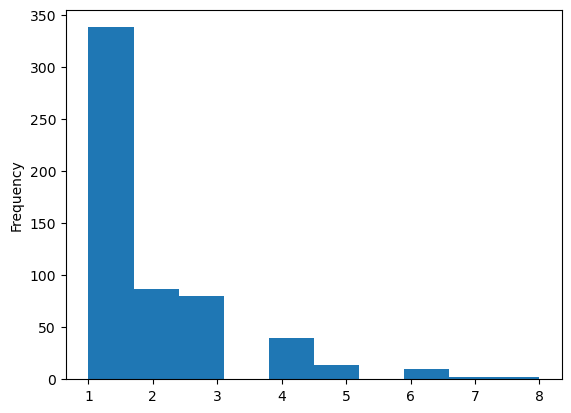

In [136]:
df_feature['Centroids'].apply(len).plot(kind='hist')